# Library

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna


from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data Loading

In [14]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [15]:
train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [16]:
test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


# Feature Engineering

- Add new feature

In [17]:
def create_features(df):
    """
    与えられたデータフレームに対して特徴量エンジニアリングを行う関数。

    Args:
    df (DataFrame): 特徴量エンジニアリングを行うデータフレーム

    Returns:
    DataFrame: 新しい特徴量が追加されたデータフレーム
    """
    # キルとデスの比率
    df['killDeathRatio'] = df['blueKills'] / (df['blueDeaths'] + 1)  # ゼロ除算を防ぐために+1

    # アシストの割合
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)

    # ヘラルドの討伐数
    df['blueHerald'] = df['blueEliteMonsters'] - df['blueDragons']
    # blueHerald列の負の値を0で置き換え
    df['blueHerald'] = df['blueHerald'].clip(lower=0)

    # エリートモンスターとドラゴンの比率
    df['eliteMonsterDragonRatio'] = df['blueEliteMonsters'] / (df['blueDragons'] + 1)
    # エリートモンスターとヘラルドの比率
    df['eliteMonsterHeraldRatio'] = df['blueEliteMonsters'] / (df['blueHerald'] + 1)

    # ゴールドと経験値の対数変換
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])

    # ゴールドと経験値の相互作用
    df['goldXexperience'] = df['blueTotalGold'] * df['blueTotalExperience']

    # 初期キルの影響
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    
    # キル、デス、アシストの合計
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    # キル・デス・アシスト比率
    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    # 効率的なリソース利用
    df['goldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1
    df['experiencePerKill'] = df['blueTotalExperience'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1

    # エリートモンスターの討伐効率
    df['eliteMonstersPerGold'] = df['blueEliteMonsters'] / df['blueTotalGold']
    df['eliteMonstersPerExperience'] = df['blueEliteMonsters'] / df['blueTotalExperience']

    # チームの総合力
    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']

    return df

- Apply data

In [18]:
train = create_features(train)
test = create_features(test)

# model

- LightGBM

[I 2024-01-18 12:57:40,117] A new study created in memory with name: no-name-54513758-7d0e-4f89-904f-745dc61931a6


Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:40,810] Trial 0 finished with value: 0.800625 and parameters: {'lambda_l1': 4.251596072546619e-07, 'lambda_l2': 2.1904912309850775, 'num_leaves': 162, 'feature_fraction': 0.41549240512166163, 'bagging_fraction': 0.49168405300860163, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 0 with value: 0.800625.
[I 2024-01-18 12:57:40,851] Trial 1 finished with value: 0.796875 and parameters: {'lambda_l1': 3.314852191608292e-08, 'lambda_l2': 5.305370251772837e-07, 'num_leaves': 14, 'feature_fraction': 0.7640778712549676, 'bagging_fraction': 0.7203817123732865, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 0 with value: 0.800625.
[I 2024-01-18 12:57:40,903] Trial 2 finished with value: 0.801875 and parameters: {'lambda_l1': 0.2014887578026684, 'lambda_l2': 6.927891903363408e-07, 'num_leaves': 31, 'feature_fraction': 0.841534191933786, 'bagging_fraction': 0.6926455653764012, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 2 with value: 0.8018

Early stopping, best iteration is:
[43]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.203125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:41,082] Trial 3 finished with value: 0.809375 and parameters: {'lambda_l1': 0.0008789109496877629, 'lambda_l2': 1.7598030073687152e-06, 'num_leaves': 57, 'feature_fraction': 0.6258465914440623, 'bagging_fraction': 0.9263459600692978, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 3 with value: 0.809375.
[I 2024-01-18 12:57:41,179] Trial 4 finished with value: 0.799375 and parameters: {'lambda_l1': 0.00023421311162465574, 'lambda_l2': 0.04049043132702249, 'num_leaves': 223, 'feature_fraction': 0.7757578946805959, 'bagging_fraction': 0.5471178522711422, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 3 with value: 0.809375.
[I 2024-01-18 12:57:41,233] Trial 5 finished with value: 0.7975 and parameters: {'lambda_l1': 1.6984050111358609e-06, 'lambda_l2': 4.261707718725096e-06, 'num_leaves': 224, 'feature_fraction': 0.9728139318760398, 'bagging_fraction': 0.47581778974134264, 'bagging_freq': 3, 'min_child_samples': 42}. Best is trial 3 with value: 

Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.200625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.2025
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:41,309] Trial 6 finished with value: 0.804375 and parameters: {'lambda_l1': 3.29629159274869e-08, 'lambda_l2': 3.314610041425914e-08, 'num_leaves': 180, 'feature_fraction': 0.883550735938067, 'bagging_fraction': 0.9299415132740941, 'bagging_freq': 1, 'min_child_samples': 87}. Best is trial 3 with value: 0.809375.
[I 2024-01-18 12:57:41,364] Trial 7 finished with value: 0.78875 and parameters: {'lambda_l1': 4.9173405518270734e-08, 'lambda_l2': 0.06723521126741969, 'num_leaves': 11, 'feature_fraction': 0.8075085415131598, 'bagging_fraction': 0.6565459847306261, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 3 with value: 0.809375.
[I 2024-01-18 12:57:41,422] Trial 8 finished with value: 0.795625 and parameters: {'lambda_l1': 6.605710800557836, 'lambda_l2': 0.02010045257799128, 'num_leaves': 133, 'feature_fraction': 0.686034174280173, 'bagging_fraction': 0.844765513875686, 'bagging_freq': 6, 'min_child_samples': 55}. Best is trial 3 with value: 0.809375.


Early stopping, best iteration is:
[32]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.21125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_error: 0.204375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_error: 0.19625


[I 2024-01-18 12:57:41,479] Trial 9 finished with value: 0.80375 and parameters: {'lambda_l1': 0.025354260998567704, 'lambda_l2': 0.01399236706508386, 'num_leaves': 96, 'feature_fraction': 0.6951859260234008, 'bagging_fraction': 0.4160470013545467, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 3 with value: 0.809375.
[I 2024-01-18 12:57:41,585] Trial 10 finished with value: 0.799375 and parameters: {'lambda_l1': 0.0002492127265520921, 'lambda_l2': 5.835681537882855e-05, 'num_leaves': 79, 'feature_fraction': 0.5917181923412435, 'bagging_fraction': 0.995417350684094, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 3 with value: 0.809375.
[I 2024-01-18 12:57:41,676] Trial 11 finished with value: 0.801875 and parameters: {'lambda_l1': 5.290478522414201e-06, 'lambda_l2': 1.4620730142365727e-08, 'num_leaves': 174, 'feature_fraction': 0.97347644011457, 'bagging_fraction': 0.9901103581337738, 'bagging_freq': 4, 'min_child_samples': 76}. Best is trial 3 with value: 0.8093

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.200625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:41,788] Trial 12 finished with value: 0.804375 and parameters: {'lambda_l1': 4.54539266942847e-05, 'lambda_l2': 1.265385557490576e-08, 'num_leaves': 69, 'feature_fraction': 0.5754366806427783, 'bagging_fraction': 0.8814203105859832, 'bagging_freq': 4, 'min_child_samples': 100}. Best is trial 3 with value: 0.809375.
[I 2024-01-18 12:57:41,910] Trial 13 finished with value: 0.804375 and parameters: {'lambda_l1': 0.004076393467246377, 'lambda_l2': 3.3770539855904856e-05, 'num_leaves': 177, 'feature_fraction': 0.9056903816993764, 'bagging_fraction': 0.8736683296940347, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 3 with value: 0.809375.


Early stopping, best iteration is:
[38]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:42,005] Trial 14 finished with value: 0.804375 and parameters: {'lambda_l1': 1.4782722220482765e-08, 'lambda_l2': 1.7309321408742358e-07, 'num_leaves': 126, 'feature_fraction': 0.899024182841904, 'bagging_fraction': 0.8068881383116769, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 3 with value: 0.809375.
[I 2024-01-18 12:57:42,136] Trial 15 finished with value: 0.801875 and parameters: {'lambda_l1': 9.294712728287644e-06, 'lambda_l2': 4.204250336468864e-06, 'num_leaves': 246, 'feature_fraction': 0.6174279063249799, 'bagging_fraction': 0.9275764880490338, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 3 with value: 0.809375.


Early stopping, best iteration is:
[7]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:42,325] Trial 16 finished with value: 0.81 and parameters: {'lambda_l1': 3.197719232611759e-07, 'lambda_l2': 9.011708871886384e-08, 'num_leaves': 46, 'feature_fraction': 0.8661589001429819, 'bagging_fraction': 0.804977711159347, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:42,461] Trial 17 finished with value: 0.808125 and parameters: {'lambda_l1': 0.001320582094812973, 'lambda_l2': 0.000647118387062244, 'num_leaves': 48, 'feature_fraction': 0.7249727690530073, 'bagging_fraction': 0.7984821073415209, 'bagging_freq': 6, 'min_child_samples': 67}. Best is trial 16 with value: 0.81.


Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_error: 0.191875


[I 2024-01-18 12:57:42,547] Trial 18 finished with value: 0.785625 and parameters: {'lambda_l1': 2.5047060187383963e-05, 'lambda_l2': 1.254246460011231e-07, 'num_leaves': 52, 'feature_fraction': 0.8402402566396774, 'bagging_fraction': 0.7708804694518538, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:42,689] Trial 19 finished with value: 0.804375 and parameters: {'lambda_l1': 6.153207588219971e-07, 'lambda_l2': 1.3838104159655392e-06, 'num_leaves': 98, 'feature_fraction': 0.99595808608299, 'bagging_fraction': 0.753801571019226, 'bagging_freq': 7, 'min_child_samples': 39}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.214375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.195625


[I 2024-01-18 12:57:42,813] Trial 20 finished with value: 0.801875 and parameters: {'lambda_l1': 6.678628687986601e-05, 'lambda_l2': 1.1618525087734104e-07, 'num_leaves': 42, 'feature_fraction': 0.6378121415363602, 'bagging_fraction': 0.8371471331945692, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:42,948] Trial 21 finished with value: 0.800625 and parameters: {'lambda_l1': 0.00149802521968821, 'lambda_l2': 0.0012801606953760365, 'num_leaves': 65, 'feature_fraction': 0.7401280889969069, 'bagging_fraction': 0.8078495903252638, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.199375


[I 2024-01-18 12:57:43,047] Trial 22 finished with value: 0.8 and parameters: {'lambda_l1': 0.001027217935190464, 'lambda_l2': 2.6827136175583487e-05, 'num_leaves': 29, 'feature_fraction': 0.707907123910831, 'bagging_fraction': 0.909470588106436, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.1925


[I 2024-01-18 12:57:43,210] Trial 23 finished with value: 0.8075 and parameters: {'lambda_l1': 0.00011628625099529961, 'lambda_l2': 0.000418996828291665, 'num_leaves': 97, 'feature_fraction': 0.5350281528302383, 'bagging_fraction': 0.8134338108593888, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:43,324] Trial 24 finished with value: 0.798125 and parameters: {'lambda_l1': 0.009719141192304798, 'lambda_l2': 5.05936663752703e-06, 'num_leaves': 57, 'feature_fraction': 0.6730998105076376, 'bagging_fraction': 0.7735351011990862, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:43,419] Trial 25 finished with value: 0.7975 and parameters: {'lambda_l1': 0.0006067351155860668, 'lambda_l2': 0.00014874527009508032, 'num_leaves': 7, 'feature_fraction': 0.7263901672633407, 'bagging_fraction': 0.8731005840617093, 'bagging_freq': 5, 'min_child_samples': 28}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.201875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	valid_0's binary_error: 0.2025
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:43,524] Trial 26 finished with value: 0.805625 and parameters: {'lambda_l1': 1.7405197920829235e-05, 'lambda_l2': 0.0009894584733159777, 'num_leaves': 120, 'feature_fraction': 0.7819949622827901, 'bagging_fraction': 0.9469417281875636, 'bagging_freq': 7, 'min_child_samples': 82}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:43,641] Trial 27 finished with value: 0.79875 and parameters: {'lambda_l1': 0.00021665560405238497, 'lambda_l2': 8.11667530163307e-06, 'num_leaves': 35, 'feature_fraction': 0.6569465208131386, 'bagging_fraction': 0.8564425441794614, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 16 with value: 0.81.


Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.20125


[I 2024-01-18 12:57:43,809] Trial 28 finished with value: 0.800625 and parameters: {'lambda_l1': 0.002388754087245455, 'lambda_l2': 1.4008072151614318e-06, 'num_leaves': 83, 'feature_fraction': 0.7426401840830534, 'bagging_fraction': 0.6482148311002125, 'bagging_freq': 4, 'min_child_samples': 29}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_error: 0.19375


[I 2024-01-18 12:57:43,953] Trial 29 finished with value: 0.80625 and parameters: {'lambda_l1': 2.272634875322895e-07, 'lambda_l2': 7.803863968147674, 'num_leaves': 150, 'feature_fraction': 0.4716301687832656, 'bagging_fraction': 0.8944989409709115, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:44,068] Trial 30 finished with value: 0.801875 and parameters: {'lambda_l1': 2.6181519952409493e-06, 'lambda_l2': 7.269086535867854e-08, 'num_leaves': 113, 'feature_fraction': 0.6557991429179592, 'bagging_fraction': 0.9470475841353143, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:44,207] Trial 31 finished with value: 0.81 and parameters: {'lambda_l1': 0.00010559641489893558, 'lambda_l2': 0.00041158914925181134, 'num_leaves': 92, 'feature_fraction': 0.5246297313567403, 'bagging_fraction': 0.8172908601355724, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	valid_0's binary_error: 0.19


[I 2024-01-18 12:57:44,375] Trial 32 finished with value: 0.803125 and parameters: {'lambda_l1': 4.633134878497079e-05, 'lambda_l2': 0.0001419946768754559, 'num_leaves': 53, 'feature_fraction': 0.5314573575736916, 'bagging_fraction': 0.747591018447903, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:44,494] Trial 33 finished with value: 0.8075 and parameters: {'lambda_l1': 0.0006836059797385156, 'lambda_l2': 5.990282686965584e-07, 'num_leaves': 76, 'feature_fraction': 0.40813427662212765, 'bagging_fraction': 0.794556684914549, 'bagging_freq': 7, 'min_child_samples': 59}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.1925


[I 2024-01-18 12:57:44,593] Trial 34 finished with value: 0.805 and parameters: {'lambda_l1': 0.02488030075699784, 'lambda_l2': 3.565782739363688e-07, 'num_leaves': 25, 'feature_fraction': 0.4546636144135756, 'bagging_fraction': 0.8295230192851548, 'bagging_freq': 5, 'min_child_samples': 48}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:44,726] Trial 35 finished with value: 0.803125 and parameters: {'lambda_l1': 7.847773547251198e-06, 'lambda_l2': 0.002395321548162105, 'num_leaves': 88, 'feature_fraction': 0.6207994726817521, 'bagging_fraction': 0.7273173220060426, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.196875


[I 2024-01-18 12:57:44,871] Trial 36 finished with value: 0.80375 and parameters: {'lambda_l1': 0.0001239903312807823, 'lambda_l2': 2.2115058588615392e-05, 'num_leaves': 48, 'feature_fraction': 0.708616980024249, 'bagging_fraction': 0.7068985190918585, 'bagging_freq': 7, 'min_child_samples': 37}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:44,968] Trial 37 finished with value: 0.796875 and parameters: {'lambda_l1': 1.2870605910527464e-06, 'lambda_l2': 3.7214574434651644e-08, 'num_leaves': 25, 'feature_fraction': 0.7682355221978352, 'bagging_fraction': 0.8551023416294625, 'bagging_freq': 5, 'min_child_samples': 57}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.203125


[I 2024-01-18 12:57:45,093] Trial 38 finished with value: 0.801875 and parameters: {'lambda_l1': 2.1606306808761966e-07, 'lambda_l2': 0.0003434775441866271, 'num_leaves': 106, 'feature_fraction': 0.7919940534416287, 'bagging_fraction': 0.7889612524909257, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:45,216] Trial 39 finished with value: 0.755625 and parameters: {'lambda_l1': 0.0005050321488591993, 'lambda_l2': 0.0028093873281998466, 'num_leaves': 3, 'feature_fraction': 0.814056062879069, 'bagging_fraction': 0.834243564216598, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.244375


[I 2024-01-18 12:57:45,342] Trial 40 finished with value: 0.798125 and parameters: {'lambda_l1': 0.004207570958704548, 'lambda_l2': 9.238020262023005e-05, 'num_leaves': 70, 'feature_fraction': 0.8682719916512703, 'bagging_fraction': 0.6789187070453153, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:45,459] Trial 41 finished with value: 0.8075 and parameters: {'lambda_l1': 0.00021860501132817028, 'lambda_l2': 0.0003181769308414859, 'num_leaves': 92, 'feature_fraction': 0.5437646164427324, 'bagging_fraction': 0.8150009245360155, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.201875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.1925


[I 2024-01-18 12:57:45,606] Trial 42 finished with value: 0.80125 and parameters: {'lambda_l1': 8.298247701936518e-05, 'lambda_l2': 0.0005881542878409108, 'num_leaves': 141, 'feature_fraction': 0.5247671365635177, 'bagging_fraction': 0.7375293452810908, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.19875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:45,775] Trial 43 finished with value: 0.81 and parameters: {'lambda_l1': 2.2462622421307355e-05, 'lambda_l2': 0.008606789756564565, 'num_leaves': 63, 'feature_fraction': 0.5882090922574811, 'bagging_fraction': 0.7743767872784757, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:45,916] Trial 44 finished with value: 0.8075 and parameters: {'lambda_l1': 2.5289739612946447e-05, 'lambda_l2': 0.007712940087589896, 'num_leaves': 63, 'feature_fraction': 0.5823256393988596, 'bagging_fraction': 0.7737059464511755, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial 16 with value: 0.81.


Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.1925


[I 2024-01-18 12:57:46,027] Trial 45 finished with value: 0.81 and parameters: {'lambda_l1': 2.4712403041752594e-06, 'lambda_l2': 0.006348677168655675, 'num_leaves': 37, 'feature_fraction': 0.6063849218215107, 'bagging_fraction': 0.8985355685338441, 'bagging_freq': 7, 'min_child_samples': 42}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:46,121] Trial 46 finished with value: 0.796875 and parameters: {'lambda_l1': 2.6978625637665397e-06, 'lambda_l2': 0.14491032108090324, 'num_leaves': 18, 'feature_fraction': 0.5993716279718542, 'bagging_fraction': 0.9043010770136892, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.203125
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:46,210] Trial 47 finished with value: 0.80125 and parameters: {'lambda_l1': 5.773365930046237e-06, 'lambda_l2': 0.09452355806552845, 'num_leaves': 40, 'feature_fraction': 0.6382759352047526, 'bagging_fraction': 0.8849377363306979, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:46,362] Trial 48 finished with value: 0.80125 and parameters: {'lambda_l1': 1.0375420272168861e-07, 'lambda_l2': 0.028032107109937362, 'num_leaves': 196, 'feature_fraction': 0.5559490258971368, 'bagging_fraction': 0.852358641155452, 'bagging_freq': 4, 'min_child_samples': 34}. Best is trial 16 with value: 0.81.


Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.19875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.19875


[I 2024-01-18 12:57:46,566] Trial 49 finished with value: 0.80125 and parameters: {'lambda_l1': 4.870548405245083e-07, 'lambda_l2': 0.006721334912950579, 'num_leaves': 78, 'feature_fraction': 0.5661357881436367, 'bagging_fraction': 0.966817981270627, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.19875


[I 2024-01-18 12:57:46,694] Trial 50 finished with value: 0.80375 and parameters: {'lambda_l1': 1.3261229080931493e-05, 'lambda_l2': 1.1595636768809006e-08, 'num_leaves': 18, 'feature_fraction': 0.5903555609504789, 'bagging_fraction': 0.9217373449908738, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:46,796] Trial 51 finished with value: 0.8025 and parameters: {'lambda_l1': 3.4880661594140195e-05, 'lambda_l2': 0.002413003924525281, 'num_leaves': 45, 'feature_fraction': 0.6857198324731967, 'bagging_fraction': 0.868292417494674, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:46,913] Trial 52 finished with value: 0.805625 and parameters: {'lambda_l1': 1.2518551815772978e-06, 'lambda_l2': 0.0008541901206230439, 'num_leaves': 62, 'feature_fraction': 0.6135330445806163, 'bagging_fraction': 0.9015221777530827, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:47,040] Trial 53 finished with value: 0.8 and parameters: {'lambda_l1': 3.884930716475914e-06, 'lambda_l2': 0.00021245790640665618, 'num_leaves': 52, 'feature_fraction': 0.9215670566509488, 'bagging_fraction': 0.8257890528099777, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial 16 with value: 0.81.


Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_error: 0.2


[I 2024-01-18 12:57:47,184] Trial 54 finished with value: 0.80625 and parameters: {'lambda_l1': 0.0004386255153994921, 'lambda_l2': 6.507055098388356e-05, 'num_leaves': 34, 'feature_fraction': 0.6384235100048419, 'bagging_fraction': 0.7954928825624304, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.19125


[I 2024-01-18 12:57:47,322] Trial 55 finished with value: 0.80875 and parameters: {'lambda_l1': 1.7842534262054742e-05, 'lambda_l2': 0.013167822163937123, 'num_leaves': 72, 'feature_fraction': 0.5669113223236918, 'bagging_fraction': 0.8448454075852221, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:47,448] Trial 56 finished with value: 0.80625 and parameters: {'lambda_l1': 8.419461896002195e-06, 'lambda_l2': 0.05074206018101438, 'num_leaves': 68, 'feature_fraction': 0.5105777668398656, 'bagging_fraction': 0.877365449294367, 'bagging_freq': 7, 'min_child_samples': 43}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:47,559] Trial 57 finished with value: 0.805625 and parameters: {'lambda_l1': 1.5430697445730376e-05, 'lambda_l2': 0.014568165566454747, 'num_leaves': 107, 'feature_fraction': 0.568717207803342, 'bagging_fraction': 0.855671945334349, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.194375


[I 2024-01-18 12:57:47,720] Trial 58 finished with value: 0.805625 and parameters: {'lambda_l1': 1.0410698346018242e-06, 'lambda_l2': 0.21090049643753342, 'num_leaves': 82, 'feature_fraction': 0.5962821208059117, 'bagging_fraction': 0.9151019249279021, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:47,938] Trial 59 finished with value: 0.798125 and parameters: {'lambda_l1': 4.1632611695022824e-05, 'lambda_l2': 0.0066406409248999515, 'num_leaves': 59, 'feature_fraction': 0.5632250266117843, 'bagging_fraction': 0.8383360909573742, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:48,050] Trial 60 finished with value: 0.8 and parameters: {'lambda_l1': 0.00011966152268917725, 'lambda_l2': 2.2472617872055077e-07, 'num_leaves': 73, 'feature_fraction': 0.5061427833897031, 'bagging_fraction': 0.9435899263228011, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 16 with value: 0.81.


Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.201875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:48,170] Trial 61 finished with value: 0.8 and parameters: {'lambda_l1': 0.00021825976297808178, 'lambda_l2': 0.0010561238357822637, 'num_leaves': 41, 'feature_fraction': 0.6689699774287395, 'bagging_fraction': 0.7641685680655366, 'bagging_freq': 6, 'min_child_samples': 52}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:48,274] Trial 62 finished with value: 0.79625 and parameters: {'lambda_l1': 3.840847773531612e-06, 'lambda_l2': 0.024605691139938414, 'num_leaves': 32, 'feature_fraction': 0.6116335224368395, 'bagging_fraction': 0.8061396934268343, 'bagging_freq': 5, 'min_child_samples': 73}. Best is trial 16 with value: 0.81.


Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.20375
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:48,410] Trial 63 finished with value: 0.803125 and parameters: {'lambda_l1': 6.31241832748206e-05, 'lambda_l2': 0.0037969489565394, 'num_leaves': 53, 'feature_fraction': 0.5775645148191225, 'bagging_fraction': 0.8914128948801235, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:48,519] Trial 64 finished with value: 0.79375 and parameters: {'lambda_l1': 1.3166844363469154e-05, 'lambda_l2': 0.0018162222072566792, 'num_leaves': 13, 'feature_fraction': 0.5441129196690111, 'bagging_fraction': 0.8229210783349086, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 16 with value: 0.81.


Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.20625
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:48,694] Trial 65 finished with value: 0.79875 and parameters: {'lambda_l1': 0.0014281827911172289, 'lambda_l2': 0.0008180321772790308, 'num_leaves': 87, 'feature_fraction': 0.7467569213788117, 'bagging_fraction': 0.7825029035830389, 'bagging_freq': 6, 'min_child_samples': 64}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:48,838] Trial 66 finished with value: 0.801875 and parameters: {'lambda_l1': 2.2836802480390023e-05, 'lambda_l2': 0.0005851763153568743, 'num_leaves': 42, 'feature_fraction': 0.6376775477738502, 'bagging_fraction': 0.7534392802447188, 'bagging_freq': 7, 'min_child_samples': 38}. Best is trial 16 with value: 0.81.


Early stopping, best iteration is:
[21]	valid_0's binary_error: 0.20125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.198125


[I 2024-01-18 12:57:48,961] Trial 67 finished with value: 0.79625 and parameters: {'lambda_l1': 0.000363998145943122, 'lambda_l2': 0.011455318881166092, 'num_leaves': 102, 'feature_fraction': 0.5974890798129276, 'bagging_fraction': 0.8679605739042285, 'bagging_freq': 6, 'min_child_samples': 84}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:49,092] Trial 68 finished with value: 0.804375 and parameters: {'lambda_l1': 0.0009842959667676024, 'lambda_l2': 1.0997986707595506e-06, 'num_leaves': 61, 'feature_fraction': 0.7125933751371754, 'bagging_fraction': 0.845033155724083, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.20375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.195625


[I 2024-01-18 12:57:49,204] Trial 69 finished with value: 0.801875 and parameters: {'lambda_l1': 2.3292603920601603e-06, 'lambda_l2': 0.0038258226048095197, 'num_leaves': 48, 'feature_fraction': 0.6845637136049665, 'bagging_fraction': 0.8084611203989343, 'bagging_freq': 5, 'min_child_samples': 80}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:49,344] Trial 70 finished with value: 0.796875 and parameters: {'lambda_l1': 0.00011432013552744491, 'lambda_l2': 0.0014830167927317116, 'num_leaves': 22, 'feature_fraction': 0.5559497485823711, 'bagging_fraction': 0.7676362706377803, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.203125


[I 2024-01-18 12:57:49,457] Trial 71 finished with value: 0.801875 and parameters: {'lambda_l1': 3.332188329308742e-05, 'lambda_l2': 0.00042407717103115617, 'num_leaves': 98, 'feature_fraction': 0.5803171208590422, 'bagging_fraction': 0.7907010754844057, 'bagging_freq': 7, 'min_child_samples': 45}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:49,598] Trial 72 finished with value: 0.801875 and parameters: {'lambda_l1': 6.330369219216961e-06, 'lambda_l2': 1.5125833789467743e-05, 'num_leaves': 126, 'feature_fraction': 0.6253240464381187, 'bagging_fraction': 0.8348539937384802, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.198125


[I 2024-01-18 12:57:49,720] Trial 73 finished with value: 0.804375 and parameters: {'lambda_l1': 0.0001665742693418262, 'lambda_l2': 0.00013607623965432539, 'num_leaves': 74, 'feature_fraction': 0.5333276287802464, 'bagging_fraction': 0.8049509868630115, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:49,840] Trial 74 finished with value: 0.809375 and parameters: {'lambda_l1': 6.546496042006873e-05, 'lambda_l2': 0.0002529687041991734, 'num_leaves': 91, 'feature_fraction': 0.5117605080707206, 'bagging_fraction': 0.8190580098268622, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.190625


[I 2024-01-18 12:57:50,032] Trial 75 finished with value: 0.8025 and parameters: {'lambda_l1': 6.152091024765134e-05, 'lambda_l2': 8.265779294312558e-08, 'num_leaves': 115, 'feature_fraction': 0.49688352624587756, 'bagging_fraction': 0.8205766441421046, 'bagging_freq': 4, 'min_child_samples': 49}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:50,154] Trial 76 finished with value: 0.80875 and parameters: {'lambda_l1': 0.00036896930199723405, 'lambda_l2': 4.351914538011948e-05, 'num_leaves': 89, 'feature_fraction': 0.5495387954421591, 'bagging_fraction': 0.892165402572813, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.19125


[I 2024-01-18 12:57:50,277] Trial 77 finished with value: 0.80375 and parameters: {'lambda_l1': 0.00031084241196760806, 'lambda_l2': 4.17463440122043e-05, 'num_leaves': 89, 'feature_fraction': 0.4843661020688865, 'bagging_fraction': 0.8950673531726268, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 16 with value: 0.81.
[I 2024-01-18 12:57:50,397] Trial 78 finished with value: 0.81 and parameters: {'lambda_l1': 7.518503882377183e-07, 'lambda_l2': 3.951890418978577e-06, 'num_leaves': 79, 'feature_fraction': 0.5482254867301068, 'bagging_fraction': 0.926935932479173, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 16 with value: 0.81.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.19


[I 2024-01-18 12:57:50,530] Trial 79 finished with value: 0.814375 and parameters: {'lambda_l1': 5.26844506200214e-07, 'lambda_l2': 5.065358260440827e-06, 'num_leaves': 79, 'feature_fraction': 0.5264524743851785, 'bagging_fraction': 0.928380297592213, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 79 with value: 0.814375.
[I 2024-01-18 12:57:50,654] Trial 80 finished with value: 0.80625 and parameters: {'lambda_l1': 2.677226659025665e-07, 'lambda_l2': 1.599889857835763e-06, 'num_leaves': 83, 'feature_fraction': 0.45383138107437354, 'bagging_fraction': 0.9731544866685624, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 79 with value: 0.814375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.185625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.19375


[I 2024-01-18 12:57:50,821] Trial 81 finished with value: 0.810625 and parameters: {'lambda_l1': 5.09990310739038e-07, 'lambda_l2': 2.434239006382372e-06, 'num_leaves': 66, 'feature_fraction': 0.5183687016949567, 'bagging_fraction': 0.9253354867923351, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 79 with value: 0.814375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.19


[I 2024-01-18 12:57:50,979] Trial 82 finished with value: 0.81 and parameters: {'lambda_l1': 4.4652477116717614e-07, 'lambda_l2': 3.2261937188752226e-06, 'num_leaves': 67, 'feature_fraction': 0.5134054939970298, 'bagging_fraction': 0.9234675397794945, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 79 with value: 0.814375.
[I 2024-01-18 12:57:51,121] Trial 83 finished with value: 0.80375 and parameters: {'lambda_l1': 8.426182514109775e-07, 'lambda_l2': 4.6829638646390085e-06, 'num_leaves': 56, 'feature_fraction': 0.5254299701443247, 'bagging_fraction': 0.9307533219219047, 'bagging_freq': 5, 'min_child_samples': 24}. Best is trial 79 with value: 0.814375.
[I 2024-01-18 12:57:51,274] Trial 84 finished with value: 0.801875 and parameters: {'lambda_l1': 6.665036892159044e-07, 'lambda_l2': 3.1374300976499136e-06, 'num_leaves': 66, 'feature_fraction': 0.5423065528038518, 'bagging_fraction': 0.9203865930163085, 'bagging_freq': 4, 'min_child_samples': 30}. Best is trial 79 with valu

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.198125


[I 2024-01-18 12:57:51,426] Trial 85 finished with value: 0.804375 and parameters: {'lambda_l1': 1.3660014318527732e-07, 'lambda_l2': 9.809937847181842e-06, 'num_leaves': 79, 'feature_fraction': 0.5318143890249718, 'bagging_fraction': 0.9431728641329457, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 79 with value: 0.814375.
[I 2024-01-18 12:57:51,532] Trial 86 finished with value: 0.79625 and parameters: {'lambda_l1': 4.2917050072924157e-07, 'lambda_l2': 3.768676618018751e-07, 'num_leaves': 58, 'feature_fraction': 0.5177450178462013, 'bagging_fraction': 0.908989728369122, 'bagging_freq': 4, 'min_child_samples': 5}. Best is trial 79 with value: 0.814375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.20375


[I 2024-01-18 12:57:51,660] Trial 87 finished with value: 0.803125 and parameters: {'lambda_l1': 1.3712807401954835e-06, 'lambda_l2': 8.829238512181959e-06, 'num_leaves': 36, 'feature_fraction': 0.49271866913377255, 'bagging_fraction': 0.9670858506027308, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 79 with value: 0.814375.
[I 2024-01-18 12:57:51,784] Trial 88 finished with value: 0.8025 and parameters: {'lambda_l1': 4.026613755914196e-07, 'lambda_l2': 2.2438213837809074e-06, 'num_leaves': 65, 'feature_fraction': 0.5562930501147361, 'bagging_fraction': 0.9926707186417802, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 79 with value: 0.814375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.1975


[I 2024-01-18 12:57:51,944] Trial 89 finished with value: 0.80125 and parameters: {'lambda_l1': 1.865548508225056e-06, 'lambda_l2': 2.769935068957063e-06, 'num_leaves': 246, 'feature_fraction': 0.5792760007472821, 'bagging_fraction': 0.9583662333745214, 'bagging_freq': 6, 'min_child_samples': 18}. Best is trial 79 with value: 0.814375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.19875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.1925


[I 2024-01-18 12:57:52,069] Trial 90 finished with value: 0.8075 and parameters: {'lambda_l1': 7.80299996296822e-08, 'lambda_l2': 9.44677883970266e-07, 'num_leaves': 49, 'feature_fraction': 0.5171082470511823, 'bagging_fraction': 0.9271492272581624, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 79 with value: 0.814375.
[I 2024-01-18 12:57:52,221] Trial 91 finished with value: 0.81 and parameters: {'lambda_l1': 7.122714532902902e-07, 'lambda_l2': 5.454684100519989e-07, 'num_leaves': 94, 'feature_fraction': 0.4995536600563562, 'bagging_fraction': 0.8794485696806668, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 79 with value: 0.814375.
[I 2024-01-18 12:57:52,334] Trial 92 finished with value: 0.806875 and parameters: {'lambda_l1': 7.073510010902408e-07, 'lambda_l2': 7.264524899614647e-07, 'num_leaves': 79, 'feature_fraction': 0.47886680093909306, 'bagging_fraction': 0.9100844102110857, 'bagging_freq': 6, 'min_child_samples': 39}. Best is trial 79 with value: 0.8

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.19
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.193125


[I 2024-01-18 12:57:52,534] Trial 93 finished with value: 0.806875 and parameters: {'lambda_l1': 2.0428825137947187e-07, 'lambda_l2': 4.612393319298898e-07, 'num_leaves': 108, 'feature_fraction': 0.49859761585329465, 'bagging_fraction': 0.8840921405614468, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 79 with value: 0.814375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:52,661] Trial 94 finished with value: 0.8075 and parameters: {'lambda_l1': 3.551998181490629e-07, 'lambda_l2': 4.9533176393019814e-06, 'num_leaves': 70, 'feature_fraction': 0.5436571296081244, 'bagging_fraction': 0.9339413360522056, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 79 with value: 0.814375.
[I 2024-01-18 12:57:52,808] Trial 95 finished with value: 0.804375 and parameters: {'lambda_l1': 8.905433793067133e-07, 'lambda_l2': 1.8594897417919012e-06, 'num_leaves': 94, 'feature_fraction': 0.5262136252289814, 'bagging_fraction': 0.8715594630393734, 'bagging_freq': 5, 'min_child_samples': 47}. Best is trial 79 with value: 0.814375.


Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.195625


[I 2024-01-18 12:57:52,964] Trial 96 finished with value: 0.8025 and parameters: {'lambda_l1': 4.909362305764488e-07, 'lambda_l2': 7.562822278030886e-07, 'num_leaves': 101, 'feature_fraction': 0.4627337532159817, 'bagging_fraction': 0.9033854317358649, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 79 with value: 0.814375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 12:57:53,167] Trial 97 finished with value: 0.806875 and parameters: {'lambda_l1': 1.7665120503782271e-06, 'lambda_l2': 2.7526508202855036e-07, 'num_leaves': 83, 'feature_fraction': 0.5672835023051895, 'bagging_fraction': 0.9201193343611894, 'bagging_freq': 7, 'min_child_samples': 33}. Best is trial 79 with value: 0.814375.
[I 2024-01-18 12:57:53,343] Trial 98 finished with value: 0.8075 and parameters: {'lambda_l1': 4.354117936206301e-08, 'lambda_l2': 1.208941661596642e-06, 'num_leaves': 133, 'feature_fraction': 0.5078894333619818, 'bagging_fraction': 0.9812533890895814, 'bagging_freq': 7, 'min_child_samples': 29}. Best is trial 79 with value: 0.814375.


Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.1925


[I 2024-01-18 12:57:53,475] Trial 99 finished with value: 0.8 and parameters: {'lambda_l1': 3.0976615022935354e-06, 'lambda_l2': 6.169448289913222e-07, 'num_leaves': 28, 'feature_fraction': 0.6043248014403391, 'bagging_fraction': 0.9559636596251991, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 79 with value: 0.814375.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.2
[1 1 0 ... 1 1 0]


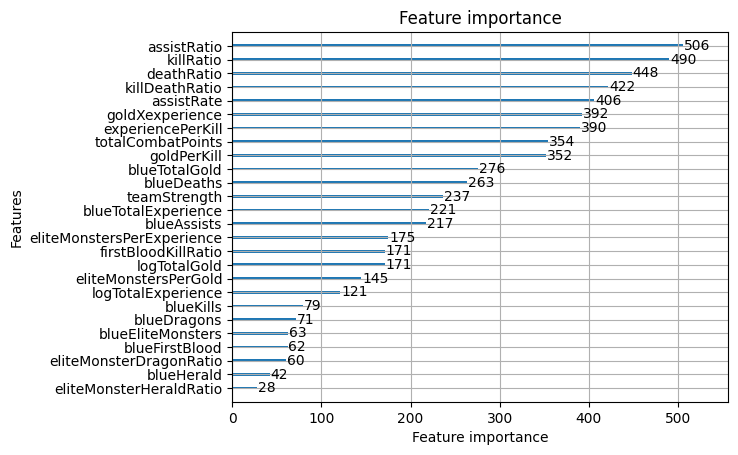

In [19]:


# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

test_drop_gameId = test.drop('gameId', axis=1)

# Optunaでのハイパーパラメータチューニング
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    verbose_eval = 0
    verbose = lgb.log_evaluation(verbose_eval)

    # 早期停止の設定
    early_stopping = lgb.early_stopping(stopping_rounds=10, verbose=True)
    model = lgb.train(param, lgb_train, num_boost_round=1000, valid_sets=[lgb_val], callbacks=[early_stopping, verbose])
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最適なハイパーパラメータでモデルを再学習
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_error'
best_params['verbosity'] = -1

lgb_train = lgb.Dataset(X, y)
model = lgb.train(best_params, lgb_train, num_boost_round=study.best_trial.number)

# テストデータに対する予測
y_test_pred = model.predict(test_drop_gameId)
y_test_pred_int = (y_test_pred > 0.5).astype(int)

# 予測結果の表示
print(y_test_pred_int)

# 特徴量の重要度をプロット
# importance_typeは'split'または'gain'のいずれかに設定できます。
# 'split'は特徴量が分割に使用された回数に基づく重要度を表示します。
# 'gain'は特徴量がモデルのパフォーマンス向上にどれだけ貢献したかを表示します。
lgb.plot_importance(model, importance_type='split', max_num_features=30)
plt.show()

- testにy_test_pred結合

In [20]:
output = '../data/output/submit_cv_oputuna_add_feature_drop_gameId.csv'

In [21]:
submit = pd.DataFrame({
    '0': test['gameId'],
    '1': y_test_pred_int
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

- 出力csvチェック

In [22]:
check = pd.read_csv(output)

In [23]:
check

,9,1
0,15,1
1,18,0
2,23,0
3,31,0
4,32,1
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
